In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install pycountry_convert

In [3]:
#load dataset downloaded from https://www.worldbank.org/
life_exp = pd.read_csv("data/API_SP.DYN.LE00.IN_DS2_en_csv_v2_1622191.csv", header = 2)
fertility = pd.read_csv("data/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_1622869.csv", header = 2)
population = pd.read_csv("data/API_SP.POP.TOTL_DS2_en_csv_v2_1637443.csv", header = 2)

In [4]:
# display(life_exp.head())
# display(fertility.head())
# display(population.head())

In [5]:
#check columns with high nulls
nulls_col = life_exp.isnull().mean()
display("Life Expectancy:", nulls_col.sort_values(ascending = False).head())

nulls_col = fertility.isnull().mean()
display("Fertility:", nulls_col.sort_values(ascending = False).head())

nulls_col = population.isnull().mean()
display("Population:", nulls_col.sort_values(ascending = False).head())

'Life Expectancy:'

Unnamed: 65    1.000000
2019           1.000000
2020           1.000000
1960           0.109848
1963           0.109848
dtype: float64

'Fertility:'

Unnamed: 65    1.000000
2019           1.000000
2020           1.000000
1963           0.109848
1960           0.106061
dtype: float64

'Population:'

Unnamed: 65    1.000000
2020           1.000000
1960           0.015152
1975           0.015152
1987           0.015152
dtype: float64

In [6]:
redun_col = ["Country Code", "Indicator Name", "Indicator Code", "Unnamed: 65", "2019", "2020"]
#drop redundant and all nulls columns
life_exp.drop(redun_col, axis = 1, inplace = True)
fertility.drop(redun_col, axis = 1, inplace = True)
population.drop(redun_col, axis = 1, inplace = True)

In [7]:
#check rows with high nulls
nulls_row = (life_exp.isnull().sum(axis = 1)) / (life_exp.shape[1] - 1)
display("Life Expectancy: ", nulls_row.sort_values(ascending = False).head(5))

nulls_row = (fertility.isnull().sum(axis = 1)) / (life_exp.shape[1] - 1)
display("Fertility: ", nulls_row.sort_values(ascending = False).head(5))

nulls_row = (population.isnull().sum(axis = 1)) / (life_exp.shape[1] - 1)
display("Population: ", nulls_row.sort_values(ascending = False).head(5))

'Life Expectancy: '

82     1.0
147    1.0
177    1.0
4      1.0
226    1.0
dtype: float64

'Fertility: '

243    1.0
177    1.0
82     1.0
50     1.0
162    1.0
dtype: float64

'Population: '

108    1.000000
223    0.644068
194    0.508475
212    0.508475
67     0.118644
dtype: float64

In [8]:
#fill NaNs that are in between years with data
life_exp.iloc[:, 1:] = life_exp.iloc[:, 1:].ffill(axis = 1)
fertility.iloc[:, 1:] = fertility.iloc[:, 1:].ffill(axis = 1)
population.iloc[:, 1:] = population.iloc[:, 1:].ffill(axis = 1)

#drop rows with all NaN
life_exp = life_exp.drop(nulls_row[nulls_row == 1].index.tolist(), axis = 0)

#drop rows with NaN
fertility = fertility.drop(nulls_row[nulls_row > 0].index.tolist(), axis = 0)
population = population.drop(nulls_row[nulls_row > 0].index.tolist(), axis = 0)

In [9]:
#categorize country into continents
import pycountry_convert as pc

def convert_continent (data) :
    continent = []
    for i in range(len(data)) :
        try :
            code = pc.country_name_to_country_alpha2(data["Country Name"][i], cn_name_format = "default")
        except KeyError :
            code = "Not a Country"
        try :
            continent.append(pc.country_alpha2_to_continent_code(code))
        except KeyError :
            continent.append("Not a Country")
        # print(data["Country Name"][i], continent[i])
    return (pd.Series(continent))

life_exp["Continent"] = convert_continent(life_exp)
fertility["Continent"] = convert_continent(fertility)
population["Continent"] = convert_continent(population)

#delete all rows that are not a country
life_exp = life_exp[life_exp["Continent"] != "Not a Country"]
fertility = fertility[fertility["Continent"] != "Not a Country"]
population = population[population["Continent"] != "Not a Country"]

#delete all rows that are NaN
life_exp = life_exp[life_exp["Continent"].notnull()]
fertility = fertility[fertility["Continent"].notnull()]
population = population[population["Continent"].notnull()]

In [10]:
#make country name index
life_exp.set_index("Country Name", drop = True, inplace = True)
fertility.set_index("Country Name", drop = True, inplace = True)
population.set_index("Country Name", drop = True, inplace = True)

In [11]:
display(np.array_equal(fertility.index, population.index)) #fertility and population has the same countries

True

In [12]:
#get the countries that are common in all three dataframes
countries = np.intersect1d(life_exp.index, fertility.index)

#retain only the common countries in all dataframes
life_exp = life_exp.loc[countries]
fertility = fertility.loc[countries]
population = population.loc[countries]

<IPython.core.display.Javascript object>


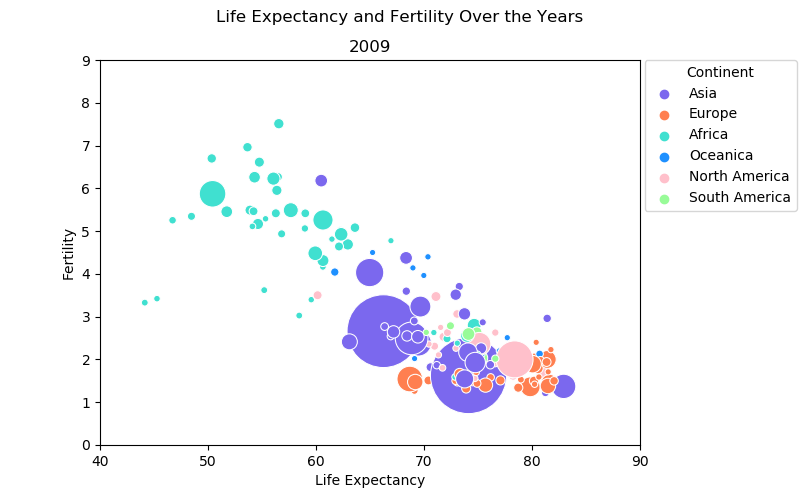

In [13]:
%matplotlib notebook
fig, ax = plt.subplots(figsize = (8, 5))

fig.suptitle("Life Expectancy and Fertility Over the Years")
fig.subplots_adjust(right = .8)

new_labels = ["Asia", "Europe", "Africa", "Oceanica", "North America", "South America"]
set_colors = {"AS" : "mediumslateblue", "EU" : "coral", "AF" : "turquoise", "OC" : "dodgerblue",
              "NA" : "pink", "SA" : "palegreen"
             }

def animate (i):
    plt.cla() #clear axes so that the points doesn't retain as we move on to the next time period 
    le = life_exp.iloc[:, :-1]
    f = fertility.iloc[:, :-1]
    p = population.iloc[:, :-1]
    ax = sns.scatterplot(x = le.iloc[:, i],
                         y = f.iloc[:, i],
                         hue = life_exp["Continent"], palette = set_colors,
                         size = p.iloc[:, i],
                         sizes = (20, 3000),
                        )
    ax.set(xlabel = "Life Expectancy", ylabel = "Fertility")
    h, l = ax.get_legend_handles_labels() #get handle and label of legend
    plt.legend(h[1:7], #put through handles for the 6 continents
               ["Asia", "Europe", "Africa", "Oceanica", "North America", "South America"], #rename the labels for continents
               bbox_to_anchor=(1.29, 1), loc = "top right", borderaxespad = 0, title = "Continent",
              )
    plt.title(le.iloc[:, i].name) #create a subtitle to display the year
    plt.xlim(40, 90)
    plt.ylim(0, 9)


import matplotlib.animation as animation
ani = animation.FuncAnimation(fig, animate,
                              frames = len(life_exp.iloc[:, :-1].columns),
                              interval = 100,
                              repeat = True
                             )

plt.show()

In [14]:
# #set up movie file formatting
# Writer = animation.writers["ffmpeg"]
# writers = Writer(fps = 15, metadata = dict(artist = "Deborah Cheng"), bitrate = 1800)

# #save the graph in mp4
# ani.save("life_exp_v_fertility.mp4", writer = writers)

In [15]:
#set up writer parameter
writer_gif = animation.PillowWriter(fps = 60)

#save the graph in gif
ani.save("life_exp_v_fertility.gif", writer = writer_gif)